# Multiclass Classification & Weight Visualization

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
from sklearn import datasets
import random
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Setup Seed

For experiment reproducibility (in most cases), we need to make sure all sources of randomness are initialized with a seed. This includes the Python module `random` and `numpy`. Ideally, experiments should be run using multiple seeds to make sure results don't fit to a seed.

**IMPORTANT**: Before using a random number generator from any module, make sure to set the seed using that module's seed function.

In [2]:
# Set random seed
np.random.seed(12345)

## Fetch Data

Download the MNIST dataset file `mnist.npz` from [NYU Box](https://nyu.box.com/s/a7gsf7ouxm1qrqcoqa3rwdmc6awh0070).

In [3]:
! wget 'https://nyu.box.com/shared/static/a7gsf7ouxm1qrqcoqa3rwdmc6awh0070.npz' -O '/content/sample_data/mnist.npz'

/content/sample_data/mnist.npz: No such file or directory


## Read Data

In [4]:
# Class for loading MNIST data
class MNIST:
    def __init__(self, path):
        mnist = pickle.load(open(path,"rb"))

        self.train_labels = mnist['train_labels']
        self.test_labels = mnist['test_labels']

        self.train_data = mnist['train_data']
        self.train_data = self.train_data.reshape(self.train_data.shape[0], -1)
        self.test_data = mnist['test_data']
        self.test_data = self.test_data.reshape(self.test_data.shape[0], -1)

**NOTE**: Modify the `path` argument as desired.

In [5]:
# Load data
path = './qmnist.pkl'
mnist = MNIST(path)

Each digit is represented by a $784$-D vector (flattened $28 \times 28$ image) and has a corresponding target digit label.

In [6]:
# Explore data
mnist.train_data.shape, mnist.train_labels.shape

((60000, 784), (60000,))

Let's take a look at the digits distribution in the dataset.

In [7]:
# Count the number of images per class
pd.DataFrame({
    'count': np.bincount(mnist.train_labels),
    'digit': np.unique(mnist.train_labels)}, 
    columns=['digit', 'count'])

,digit,count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


## Create Train/Validation/Test Data

To make sure we create a model that generalizes well, we should train our model **ONLY** on "train" data, find the best performing model (validation) via the "validation" data and make sure no novel data ("test" data) leaks into the training or validation phase.

For illustration, we will use $1000$ training samples, $100$ validation and test samples, all chosen (pseudo-)randomly. We first randomly pick a set of indices from both train and test data.

In [8]:
# Train, validation, test indices
num_train, num_val, num_test = 1000, 100, 100
sample_idx = np.random.choice(mnist.train_data.shape[0], num_train + num_val)
test_idx = np.random.choice(mnist.test_data.shape[0], num_test)
train_idx, val_idx = (sample_idx[:num_train], sample_idx[num_train:num_train + num_val])

We simply use numpy slicing to get the data at the indices sampled above.

In [9]:
# Train, validation, test split
train_data, train_labels = mnist.train_data[train_idx], mnist.train_labels[train_idx].astype(np.int)
val_data, val_labels = mnist.train_data[val_idx], mnist.train_labels[val_idx].astype(np.int)
test_data, test_labels = mnist.test_data[test_idx], mnist.test_labels[test_idx].astype(np.int)

We add the bias element directly into the original data by concatenating a column of ones.

In [10]:
# Adjust append a column to account for for bias 
train_data_tilde = np.concatenate([train_data, np.ones((train_data.shape[0], 1))], axis=1)
val_data_tilde = np.concatenate([val_data, np.ones((val_data.shape[0], 1))], axis=1)
test_data_tilde = np.concatenate([test_data, np.ones((test_data.shape[0], 1))], axis=1)

# Sanity check
train_data_tilde.shape, val_data_tilde.shape, test_data_tilde.shape

((1000, 785), (100, 785), (100, 785))

## Visualize Train Data

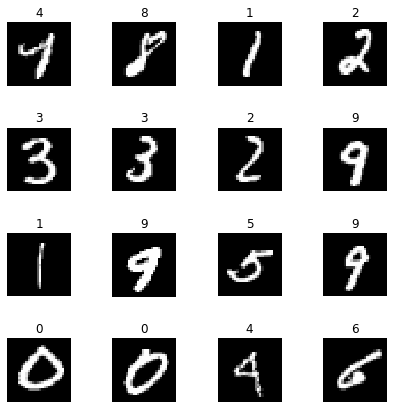

In [11]:
# Visualize data
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
fig.tight_layout()

random_idx = np.random.choice(train_data.shape[0], size=16, replace=False)

for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        axes[i, j].set_title(train_labels[idx])
        axes[i, j].imshow(train_data[idx].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')

plt.show()

Let's also take a look at the label distribution for our newly created training data. Ideally, we would like them to be equal in number.

In [12]:
# The number of images per class in the training set
pd.DataFrame({
    'count': np.bincount(train_labels),
    'digit': np.unique(train_labels)}, 
    columns=['digit', 'count'])

,digit,count
0,0,100
1,1,114
2,2,88
3,3,102
4,4,98
5,5,88
6,6,92
7,7,124
8,8,91
9,9,103


## Model Definition

We define a very simple model which outputs the probability of incoming digit belonging to one of the $10$ classes.

$$ 
\begin{align}
\mathbf{p} &= \text{softmax}(XW^T) \tag{$X \in \mathbb{R}^{M \times (D+1)}$, $W \in \mathbb{R}^{K \times (D+1)}$} \\
\text{softmax}(v_i) &= \frac{\exp{v_i}}{\sum_j \exp{v_j}} \tag{$\forall i \in [1, K]$}
\end{align}
$$

$M$ is the number of samples, $D = 784$, $K = 10$ total number of classes.

### Model
We code up the formulas from above. You can notice that in the first line, after the matrix multiplication operation, the resulting matrix is divided by a constant. This is done to avoid overflow; dividing by constant won't change the overall result if the softmax operation. 

In [13]:
# Model 
def model(X, W):
    ''' This function takes as input:
            - data X of shape (M, D+1)
            - weight matrix W of shape (K, D+1)
        and returns 
            - the softmax predictions for each data sample over all classes
    ''' 
    logits = np.matmul(X, W.T) / W.shape[-1] # logits.shape is (M, K)
    logits_exp = np.exp(logits)
    logits_exp_sum = np.sum(logits_exp, axis=1, keepdims=True) # sum each row; logits_exp_sum.shape is (M, 1)
    probs = logits_exp / logits_exp_sum # probs.shape is (M, K)
    return probs

# Sanity check 
X = val_data_tilde
W = np.ones((10, X.shape[1]))
probs = model(X, W)
print(f"Shape of model output: {probs.shape},  Sum of elements in last row: {probs[0].sum()}")

Shape of model output: (100, 10),  Sum of elements in last row: 0.9999999999999999


### Empirical Cost
We'll define the empirical cost function we saw in class:
$$ 
\begin{align}
J(W,b)\colon = \frac{1}{M} \sum_{m=1}^M \big(-\log[~p(y^*_m~|~x_m; W, b)~]\big)
\end{align}
$$
where $y^*_m$ is the ground truth class for input data $x_m\colon =X[m]$.

In [14]:
# Mean negative log-likelihood
def mean_nll(W, X, y):
    output = model(X, W)
   
    prob_correct_class = output[np.arange(output.shape[0]), y] # shape (M, 1)
    
    neg_log_likelihood = - np.log(prob_correct_class + 1e-9) # added 1e-9 for stability
    return np.mean(neg_log_likelihood) # scalar



## Regularization
Weight decay is a popular regularization technique. It equals the squared sum of the weight parameters multiplied by a scalar hyperparamter $\alpha > 0$. Adding this weight decay term to the loss penalizes the norm of the parameters.

In [15]:
# Adding weight decay to the negative log-likelihood loss
def regularized_loss(W, X, y, alpha=0.05):
    nll_loss = mean_nll(W, X, y)
    weight_decay = alpha*np.sum(W*W)
    return nll_loss + weight_decay

### Gradient with jax

In [16]:
import jax.numpy as np
import numpy as np_old
from jax import grad, jit

# Gradient function
grad_nll = jit(grad(regularized_loss))

### Model Evaluation

In [17]:
# Function computing the loss and the accuracy of the model
def evaluate(W, X, y):
    all_probs = model(X, W)
    loss = regularized_loss(W, X, y)
    y_pred = np_old.argmax(all_probs, axis=1)
    y_correct = np_old.sum(y_pred == y)
    acc = y_correct / y.shape[0]
    return loss, acc

## Execute Training

We first initialize all weights randomly from a standard normal distribution and then run training until we see no further improvement (for a maximum of `n_epochs`).


### Gradient Descent

Often times, we cannot solve for the true parameters in closed form and resort to an iterative procedure known as *gradient descent*. Further, using only one data sample to update the parameters is termed as *stochastic gradient descent*. The stochasticity (randomness) comes from the fact that we only use one sample and not the full data set. To maximize memory utilization, we take a subset of samples called a *mini-batch*, termed as *mini-batch stochastic gradient descent*. This technique is demonstrated in the example below.

The stochastic gradient algorithm involves a set of hyperparameters that typically require tuning based on the problem at hand. The learning rate is a multiplicative factor to the *stochastic gradient* which decides how far we jump in the gradient direction (modifies the magnitude of the gradient). As we start getting closer to the optimum value, we would like to slow down so as to not make large jumps in the parameter ($\mathbf{W}$) space. This schedule of decreasing the learning rate is known as *annealing*. In the example below, we anneal from a learning rate of $0.1$ to $0.001$ over $500$ epochs.

In [18]:
# Obtain number of classes and data dimension
K = np_old.unique(mnist.train_labels).shape[0]
D = mnist.train_data.shape[-1]

# Initialize weight matrix
W_init = np_old.random.normal(size=(K, D+1)) # numpy array
W = np.array(W_init) # jax.numpy array
W.shape

/Users/owenjones/ML/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(10, 785)

## Training Loop

In [19]:
# Training loop
n_epochs = 200
batch_size = 100
lr0 = 0.1
lrf = 0.001
anneal_over = 200
improvement = 0.999

best_w, old_loss = None, np_old.Inf

for e in range(n_epochs):
    lr = max(lrf, lr0 + (lrf - lr0) * (e / anneal_over))

    # 
    for b in range(num_train // batch_size):
        minibatch_X = train_data_tilde[b * batch_size:(b + 1) * batch_size]
        minibatch_y = train_labels[b * batch_size:(b + 1) * batch_size]
        dW = grad_nll(W, minibatch_X, minibatch_y)
        W -= lr * dW
    
    # Print accuracy and loss on validation data every 50 epochs
    val_loss, val_acc = evaluate(W, val_data_tilde, val_labels)
    if e % 50 == 0 or e == n_epochs -1:
        print ('epoch {:4d} : lr {:.4f} val acc {:.4f} | loss {:.5f}'.format(e, lr, val_acc, val_loss))
    
    # Save W with best validation accuracy performance
    if val_loss < old_loss:
        best_w = W
    
    # Early stopping
    if val_loss / old_loss >= improvement:
        print ('epoch {:4d} : lr {:.4f} val acc {:.4f} | loss {:.5f}'.format(e, lr, val_acc, val_loss))
        break

    old_loss = val_loss
        
test_loss, test_acc = evaluate(best_w, test_data_tilde, test_labels)
print ('\nTest acc {:.4f} | loss {:.5f}'.format(test_acc, test_loss))

epoch    0 : lr 0.1000 val acc 0.1300 | loss 321.98230
epoch   50 : lr 0.0753 val acc 0.7100 | loss 1.99071
epoch   59 : lr 0.0708 val acc 0.7200 | loss 1.95688

Test acc 0.7900 | loss 1.92765


## Visualize Features

If everything goes well, we should be able to visualize each row of the parameter matrix $W$ defined above and start seeing some patterns. Intuitively, these can be thought of as a visual association of parameters with parts of the image space. The brighter the visual, the higher the response signal on interaction with the input.

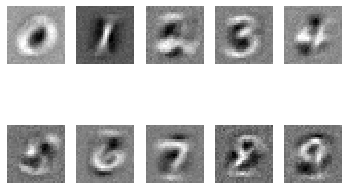

In [20]:
# Plot the patterns learned by the weight matrix 
fig, axes = plt.subplots(2, 5)

for i in range(2):
    for j in range(5):
        idx = j + i * 5
        axes[i, j].imshow(best_w[idx, :-1].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')

plt.show()